In [21]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sot2542/coffee-bean-dataset-v1")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'coffee-bean-dataset-v1' dataset.
Path to dataset files: /kaggle/input/coffee-bean-dataset-v1


In [22]:
import torch, torchvision
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader

In [23]:
for a, b, c in os.walk("/kaggle/input/coffee-bean-dataset-v1"):
  print(a)
  print(b)
  print(c)

/kaggle/input/coffee-bean-dataset-v1
['data_image_png_3024x3024']
[]
/kaggle/input/coffee-bean-dataset-v1/data_image_png_3024x3024
['coffee_dataset']
[]
/kaggle/input/coffee-bean-dataset-v1/data_image_png_3024x3024/coffee_dataset
['test', 'train']
[]
/kaggle/input/coffee-bean-dataset-v1/data_image_png_3024x3024/coffee_dataset/test
['Dark', 'Green', 'Light', 'Medium']
[]
/kaggle/input/coffee-bean-dataset-v1/data_image_png_3024x3024/coffee_dataset/test/Dark
[]
['dark (2).png', 'dark (95).png', 'dark (45).png', 'dark (8).png', 'dark (83).png', 'dark (15).png', 'dark (98).png', 'dark (91).png', 'dark (22).png', 'dark (23).png', 'dark (75).png', 'dark (55).png', 'dark (11).png', 'dark (39).png', 'dark (100).png', 'dark (33).png', 'dark (79).png', 'dark (44).png', 'dark (48).png', 'dark (21).png', 'dark (25).png', 'dark (43).png', 'dark (76).png', 'dark (57).png', 'dark (62).png', 'dark (4).png', 'dark (46).png', 'dark (24).png', 'dark (59).png', 'dark (99).png', 'dark (84).png', 'dark (88).

In [24]:
class CreateDataset(Dataset):
  def __init__(self, path, transforms=None):
    self.path = path
    self.transform = transforms
    self.data_len = 0
    self.data_list = []

    for dir, folders, files in os.walk(path):
      if path == dir:
        self.classes = folders
        self.class_to_index = {}
        for i, cls_name in enumerate(self.classes):
          self.class_to_index[cls_name] = i
        continue

      cls = dir.split("/")[-1]

      for file in files:
        img_pth = os.path.join(dir, file)
        self.data_list.append((img_pth, self.class_to_index[cls]))

      self.data_len += len(files)

  def __len__(self):
    return self.data_len

  def __getitem__(self, index):
    file_path, target = self.data_list[index]
    sample = Image.open(file_path)
    sample = sample.resize((224, 224))

    if self.transform:
      sample = self.transform(sample)

    return sample, target




In [25]:
for path_dir, dir_list, file_list in os.walk(path):
  print(path_dir)
  print(dir_list)
  print(file_list)

/kaggle/input/coffee-bean-dataset-v1
['data_image_png_3024x3024']
[]
/kaggle/input/coffee-bean-dataset-v1/data_image_png_3024x3024
['coffee_dataset']
[]
/kaggle/input/coffee-bean-dataset-v1/data_image_png_3024x3024/coffee_dataset
['test', 'train']
[]
/kaggle/input/coffee-bean-dataset-v1/data_image_png_3024x3024/coffee_dataset/test
['Dark', 'Green', 'Light', 'Medium']
[]
/kaggle/input/coffee-bean-dataset-v1/data_image_png_3024x3024/coffee_dataset/test/Dark
[]
['dark (2).png', 'dark (95).png', 'dark (45).png', 'dark (8).png', 'dark (83).png', 'dark (15).png', 'dark (98).png', 'dark (91).png', 'dark (22).png', 'dark (23).png', 'dark (75).png', 'dark (55).png', 'dark (11).png', 'dark (39).png', 'dark (100).png', 'dark (33).png', 'dark (79).png', 'dark (44).png', 'dark (48).png', 'dark (21).png', 'dark (25).png', 'dark (43).png', 'dark (76).png', 'dark (57).png', 'dark (62).png', 'dark (4).png', 'dark (46).png', 'dark (24).png', 'dark (59).png', 'dark (99).png', 'dark (84).png', 'dark (88).

In [26]:
num_batches = 8
num_workers = 8
pin_memory = True

T = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_data = CreateDataset("/kaggle/input/coffee-bean-dataset-v1/data_image_png_3024x3024/coffee_dataset/train", transforms=T)
test_data = CreateDataset("/kaggle/input/coffee-bean-dataset-v1/data_image_png_3024x3024/coffee_dataset/test", transforms=T)


train_dl = DataLoader(dataset=train_data, batch_size=num_batches, num_workers = 4, pin_memory = True, shuffle=True)
test_dl = DataLoader(dataset=test_data, batch_size=num_batches, num_workers = 4, pin_memory = True, shuffle=True)

In [27]:
len(train_data), len(test_data)

(1200, 400)

In [28]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print(device)

cuda


In [29]:
def validate(model, data, device):
  model.eval()
  total = 0
  correct = 0
  for i, (image, label) in enumerate(test_dl):
    image = image.to(device)
    label = label.to(device)

    x = model(image)
    prob, preds = torch.max(x, 1)
    correct += torch.sum(preds == label)

    total += preds.size(0)

  torch.cuda.empty_cache()

  return correct / total * 100

In [30]:
#VGG-like архитектура
class CoffeeCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 64, (3, 3), padding=1)
    self.act = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2)

    self.conv2 = nn.Conv2d(64, 128, (3, 3), padding=1)
    self.pool2 = nn.MaxPool2d(2)

    self.conv3 = nn.Conv2d(128, 256, (3, 3), padding=1)
    self.pool3 = nn.MaxPool2d(2)

    self.conv4 = nn.Conv2d(256, 512, (3, 3), padding=1)
    self.pool4 = nn.MaxPool2d(2)
    self.adapool = nn.AdaptiveAvgPool2d((6, 6))

    self.flat = nn.Flatten()
    self.drop = nn.Dropout(0.5)
    self.lin1 = nn.Linear(512 * 6 * 6, 512)
    self.lin2 = nn.Linear(512, 128)
    self.lin3 = nn.Linear(128, 4)


  def forward(self, x):
    x = self.pool1(self.act(self.conv1(x)))
    x = self.pool2(self.act(self.conv2(x)))
    x = self.pool3(self.act(self.conv3(x)))
    x = self.pool4(self.act(self.conv4(x)))
    x = self.adapool(x)
    x = self.flat(x)
    x = self.drop(self.act(self.lin1(x)))
    x = self.drop(self.act(self.lin2(x)))
    out = self.lin3(x)
    return out



In [31]:
num_epochs = 5
def train(lr=0.001, device=device, epochs=num_epochs):
  lf = nn.CrossEntropyLoss()
  CNN = CoffeeCNN().to(device)
  optimizer = torch.optim.Adam(CNN.parameters(), lr=lr)
  max_accuracy = 0
  accuracies = []

  for epoch in range(epochs):
    print(f"Эпоха {epoch}...")
    CNN.train()
    for i, (images, labels) in enumerate(train_dl):
      images = images.to(device, non_blocking=True)
      labels = labels.to(device, non_blocking=True)

      optimizer.zero_grad()

      preds = CNN(images)
      loss = lf(preds, labels)

      loss.backward()
      optimizer.step()

    accuracy = float(validate(CNN, test_dl, device))

    torch.cuda.empty_cache()

    if accuracy > max_accuracy:
      max_accuracy = accuracy
      accuracies.append(max_accuracy)
      print(max_accuracy)

    if accuracy >= 96:
      model_path = "coffee_model_best.pth"
      torch.save({'model_state_dict': CNN.state_dict(), 'classes': train_data.classes}, model_path)
      break

    print(f"Эпоха {epoch} завершена")

  plt.plot(accuracies)
  return CNN


Эпоха 0...
52.499996185302734
Эпоха 0 завершена
Эпоха 1...
69.5
Эпоха 1 завершена
Эпоха 2...
77.75
Эпоха 2 завершена
Эпоха 3...
92.74999237060547
Эпоха 3 завершена
Эпоха 4...
98.49999237060547


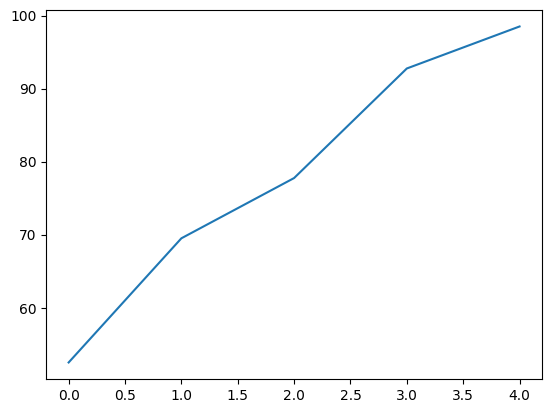

In [33]:
res = train()

In [ ]:
def save_weights(model, path="coffe_model.pth"):
  torch.save({'model_state_dict': model.state_dict(), 'classes': train_data.classes}, path)
  print(f"Модель сохранена по пути {path}")

save_weights(res)